In [1]:
import pandas as pd
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

class TextClassifier(BaseEstimator, ClassifierMixin):
    """
    Clasificador de texto basado en Multinomial Naive Bayes con pipeline y compatibilidad con scikit-learn.
    """

    def __init__(self, alpha=0.1):  
        """
        Inicializa el clasificador con el hiperparámetro alpha.
        Parámetros:
            alpha (float): Parámetro de suavizado para Naive Bayes
        """
        nltk.download('stopwords', quiet=True)
        nltk.download('wordnet', quiet=True)
        self.lemmatizer = WordNetLemmatizer()
        self.alpha = alpha
        self.pipeline = None

    def preprocess_text(self, text, stop_words):
        """
        Preprocesa un texto eliminando caracteres especiales, stopwords y aplicando lematización.

        Parámetros:
            text (str): Texto de entrada.
            stop_words (set): Lista de palabras de parada.

        Retorna:
            str: Texto transformado.
        """
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Eliminar puntuación y caracteres especiales
        text = re.sub(r'\s+', ' ', text).strip()  # Eliminar espacios extra
        text = ' '.join([word for word in text.split() if word not in stop_words])  # Eliminar stopwords
        text = ' '.join([self.lemmatizer.lemmatize(word) for word in text.split()])  # Lematización
        return text

    def fit(self, X, y):
        """
        Entrena el modelo de clasificación de texto.

        Parámetros:
            X (array): Datos de entrenamiento (textos).
            y (array): Etiquetas de entrenamiento.

        Retorna:
            self: Objeto entrenado.
        """
        print("-> Cargando stopwords y preprocesando texto...")
        stop_words = set(stopwords.words('english')) 
        X = [self.preprocess_text(text, stop_words) for text in X]

        print("-> Creando pipeline de procesamiento y modelo...")
        self.pipeline = Pipeline([
            ("tfidf", TfidfVectorizer(max_features=30000, ngram_range=(1, 2),sublinear_tf=True)),
            #("tfidf", TfidfVectorizer( ngram_range=(1, 3), min_df=2,max_df=0.9, sublinear_tf=True)),
            ("scaler", MaxAbsScaler()),            
            #("feature_selection", SelectKBest(chi2, k=15000)),
            ("classifier", MultinomialNB(alpha=self.alpha))
        ])

        print("-> Entrenando modelo...")
        self.pipeline.fit(X, y)

        # Agregar `classes_` para que sklearn lo reconozca como clasificador
        self.classes_ = np.unique(y)
        
        return self

    def predict(self, X):
        """
        Realiza predicciones en nuevos datos.

        Parámetros:
            X (array): Datos de entrada (textos).

        Retorna:
            array: Predicciones del modelo.
        """
        print("-> Cargando stopwords y preprocesando texto...")
        stop_words = set(stopwords.words('english'))
        X = [self.preprocess_text(text, stop_words) for text in X]
        return self.pipeline.predict(X)
    
    # def score(self, X, y):
    #     """
    #     Evalúa el modelo utilizando F1-score.

    #     Parámetros:
    #         X (array): Datos de validación.
    #         y (array): Etiquetas reales.

    #     Retorna:
    #         float: F1-score del modelo.
    #     """
    #     y_pred = self.predict(X)
    #     return f1_score(y, y_pred, average="macro")


In [3]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Genera y guarda la matriz de confusión.

    Parámetros:
        y_true (array): Etiquetas reales.
        y_pred (array): Predicciones del modelo.
        labels (list): Nombres de las clases.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.savefig("confusion_matrix.png")
    plt.show()



In [4]:
def train_and_save_model(train_path):
    """
    Entrena MultinomialNB con alpha=0.1 y guarda el modelo.

    Parámetros:
        train_path (str): Ruta al archivo CSV de entrenamiento.

    Retorna:
        None
    """
    print("-> Cargando datos de entrenamiento...")
    df_train = pd.read_csv(train_path)

       
    X_train, X_val, y_train, y_val = train_test_split(df_train["text"], df_train["label"], test_size=0.2, random_state=42, stratify=df_train["label"])

    print("-> Entrenando modelo con alpha=0.1...")
    model = TextClassifier(alpha=0.1)
    model.fit(X_train, y_train)

    # Evaluación en conjunto de validación
    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro')
    recall = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')

    print("\n >> Resultados en validación: <<")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")
    print(f"  - F1 Score: {f1:.4f}")

    print("\n Reporte de Clasificación:")
    print(classification_report(y_val, y_pred))

    # Generar y guardar matriz de confusión
    plot_confusion_matrix(y_val, y_pred, labels=np.unique(y_train))

    # Guardar el modelo entrenado
    with open("best_model.pkl", "wb") as f:
        pickle.dump(model, f)

    print("> Modelo guardado como 'best_model.pkl' <")



In [5]:
def train_and_save_model(train_path):
    """
    Entrena MultinomialNB con alpha=0.1 y guarda el modelo.

    Parámetros:
        train_path (str): Ruta al archivo CSV de entrenamiento.

    Retorna:
        None
    """
    print("-> Cargando datos de entrenamiento...")
    df_train = pd.read_csv(train_path)

       
    X_train, X_val, y_train, y_val = train_test_split(df_train["text"], df_train["label"], test_size=0.2, random_state=42, stratify=df_train["label"])

    print("-> Entrenando modelo con alpha=0.1...")
    model = TextClassifier(alpha=0.1)
    model.fit(X_train, y_train)

    # Evaluación en conjunto de validación
    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro')
    recall = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')

    print("\n >> Resultados en validación: <<")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")
    print(f"  - F1 Score: {f1:.4f}")

    print("\n📊 Reporte de Clasificación:")
    print(classification_report(y_val, y_pred))

    # Generar y guardar matriz de confusión
    plot_confusion_matrix(y_val, y_pred, labels=np.unique(y_train))

    # Guardar el modelo entrenado
    with open("best_model.pkl", "wb") as f:
        pickle.dump(model, f)

    print("> Modelo guardado como 'best_model.pkl' <")


def predict_with_saved_model(test_path):
    """
    Carga el modelo guardado y realiza predicciones en nuevos datos.

    Parámetros:
        test_path (str): Ruta al archivo CSV de prueba.

    Retorna:
        pd.DataFrame: DataFrame con predicciones.
    """
    print("-> Cargando modelo guardado...")
    with open("best_model.pkl", "rb") as f:
        best_model = pickle.load(f)

    df_test = pd.read_csv(test_path)
    df_test["Predicted_Label"] = best_model.predict(df_test["text"])
    df_test.to_csv("submission.csv", index=False)

    print(">> Predicciones guardadas en 'submission.csv' <<")
    return


-> Cargando datos de entrenamiento...
-> Entrenando modelo con alpha=0.1...
-> Cargando stopwords y preprocesando texto...
-> Creando pipeline de procesamiento y modelo...
-> Entrenando modelo...
-> Cargando stopwords y preprocesando texto...

 >> Resultados en validación: <<
  - Accuracy: 0.8557
  - Precision: 0.8422
  - Recall: 0.8302
  - F1 Score: 0.8351

📊 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5219
           1       0.82      0.87      0.84      3253
           2       0.81      0.84      0.83      1917
           3       0.81      0.70      0.75       890
           4       0.86      0.87      0.87       818

    accuracy                           0.86     12097
   macro avg       0.84      0.83      0.84     12097
weighted avg       0.86      0.86      0.86     12097



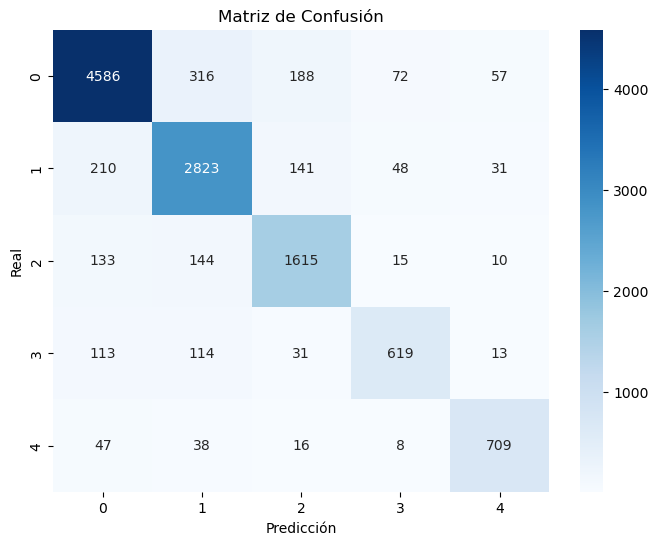

> Modelo guardado como 'best_model.pkl' <


In [18]:
train_and_save_model("data/train.csv")

In [20]:
predict_with_saved_model("data/data_test.csv")

-> Cargando modelo guardado...
-> Cargando stopwords y preprocesando texto...
>> Predicciones guardadas en 'submission.csv' <<
